In [15]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")
data_dir = "./data"

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101
Using the GPU!


In [ ]:
# !pip3 install face_recognition
!unzip /content/data.zip

In [7]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #  

    # ========= Step 1: build transformations for the dataset ===========
    # You need to construct build a data transformation that does three preprocessings in order:
    # I.   Resize the image to input_size using transforms.Resize
    # II.  Convert the image to PyTorch tensor using transforms.ToTensor
    # III. Normalize the images with the provided mean and std parameters using transforms.Normalize. These parameters are accumulated from a large number of training samples.
    # You can use transforms.Compose to combine the above three transformations. Store the combined transforms in variable 'composed_transform'.
    composed_transform = transforms.Compose([transforms.Resize(input_size), transforms.ToTensor(), transforms.Normalize(mean, std)])

    
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    # We write the remaining part of the dataloader for you.  
    # You are encouraged to go through this.

    # ========= Step 2: We build dataloaders for the downloaded data ===========
    # I.   We use torch.datasets.ImageFolder with the provided data_dir and the data transfomations you created in step 1 to contruct pytorch datasets for train/val/test 
    # II.  Then we use torch.utils.data.DataLoader to build dataloaders with the constructed pytorch datasets, you need to enable shuffling for training set. Set num_workers=2 to speed up dataloading.
    # III. Finally, we put the dataloaders into a dictionary

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}
    


    return dataloaders_dict

In [8]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 200
# of validation samples 400
# of test samples 200


In [9]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    '''

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [18]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers to get the features using the CNN.
    (That is, before the Average pooling layer in the two pictures above). 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. For use of torch.nn.Sequential, please refer to PyTorch documents.
    '''
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    layers = []
    temp = 3
    for layer in cfg:
      if layer == 'M':
        layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding = 0, dilation = 1, ceil_mode = False)]
      else:
        convolved = nn.Conv2d(temp, layer, kernel_size=(3, 3), stride = (1, 1), padding=(1, 1))
        temp = layer
        if batch_norm:
          layers+=([convolved, nn.BatchNorm2d(temp), nn.ReLU(inplace=True)])
        else:
          layers+=([convolved, nn.ReLU(inplace=True)])
    return nn.Sequential(*layers)

    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

         
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #
        # Construct the final FC layers using nn.Sequential.
        # NOTE: The avgpool layer has already been defined by us above.
         
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 3200,out_features = 512,bias= True),
            nn.ReLU(True),
            nn.Dropout(p=0.3, inplace = False),
            nn.Linear(in_features = 512,out_features = 256,bias= True),
            nn.ReLU(True),
            nn.Dropout(p=0.3, inplace = False),
            nn.Linear(in_features = 256,out_features = 100,bias= True),
        )
        
        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [19]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with the one given in the instruction above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=T

In [27]:
def make_optimizer(model):
  '''Args:model: NN to trainReturns:optimizer: pytorch optmizer for updating the given model parameters.'''
  #++++++++++++++++++++++++++++++++++++++++++++++#
  #++++++++++++++++++++++++++++++++++++++++++++++#
  # ============== YOUR CODE HERE ============== #
  # Create a SGD optimizer with a learning rate 1e-2, momentum = 0.9
  # HINT:
  # We have imported torch.optim as optim for you
  # Checkout optim.SGD() and initialize with appropriate parameters
  params_to_update=model.parameters()
  #optimizer = optim.Adam(params_to_update, lr=1e-3)
  optimizer=optim.SGD(params_to_update, lr=1e-1, momentum=0.9)
  # ============== END OF CODE ================= #
  #++++++++++++++++++++++++++++++++++++++++++++++#
  #++++++++++++++++++++++++++++++++++++++++++++++#
  return optimizer

def get_loss():
  criterion=nn.CrossEntropyLoss()
  return criterion

In [48]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 
                # ============== YOUR CODE HERE ============== #
#def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                  # Get model outputs and calculate loss
                  outputs=model(inputs)
                  loss=criterion(outputs, labels)
                  # torch.max outputs the maximum value, and its index
                  # Since the input is batched, we take the max along axis 1
                  # (the meaningful outputs)
                  _, preds=torch.max(outputs,1)
                  # backprop + optimize only if in training phase
                  if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Please read all the inputs carefully!
                # For "train" phase: 
                # (i)   Compute the outputs using model
                #       Also, use outputs to calculate predicted class by model,
                #       Store the predicted class in variable 'preds'
                #       (Think argmax of outputs across a dimension)
                #       torch.max() might help!
                # (ii)  Calculate the loss using criterion. Store it as 'loss' 
                # (iii) Update the model parameters

                # Don't forget to zero the gradients for each iteration!
                
                # For "val" phase, same as train but without backprop 
                # Compute the outputs (Same as "train", calculate 'preds' also), 
                # Calculate the loss, store it as 'loss'


                # ============== END OF CODE ================= # 
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # ================================ IMPORTANT ===============================================
                # Lossing connection to colab will lead to loss of trained weights.
                # You can download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to train the neural networks again.
                # ==========================================================================================
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

In [49]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 2

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 64 # do not change this
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [50]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 4.5366 Acc: 0.2250


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 4.3487 Acc: 0.5050
Epoch 1/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 2.7280 Acc: 0.5150


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.2324 Acc: 0.5000
Epoch 2/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 15.9712 Acc: 0.5200


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 3.5220 Acc: 0.5000
Epoch 3/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 3.8832 Acc: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 102.8992 Acc: 0.5000
Epoch 4/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 4.2404 Acc: 0.5050


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 16.0162 Acc: 0.5000
Epoch 5/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 2.3111 Acc: 0.5050


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 21.1415 Acc: 0.5000
Epoch 6/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 7.6470 Acc: 0.4600


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.9321 Acc: 0.5000
Epoch 7/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 2.1590 Acc: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.5450 Acc: 0.5000
Epoch 8/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 1.9358 Acc: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.8145 Acc: 0.5000
Epoch 9/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 1.7367 Acc: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.2262 Acc: 0.5000
Epoch 10/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 1.2642 Acc: 0.4950


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.0338 Acc: 0.4875
Epoch 11/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 1.0193 Acc: 0.5350


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8293 Acc: 0.4950
Epoch 12/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.9197 Acc: 0.4600


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7924 Acc: 0.5000
Epoch 13/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.8319 Acc: 0.5150


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7765 Acc: 0.4975
Epoch 14/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.8492 Acc: 0.4700


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7446 Acc: 0.5150
Epoch 15/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.7539 Acc: 0.5500


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7642 Acc: 0.5100
Epoch 16/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.7236 Acc: 0.5400


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7717 Acc: 0.5200
Epoch 17/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.7554 Acc: 0.5400


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7801 Acc: 0.4875
Epoch 18/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.7149 Acc: 0.5500


  0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7557 Acc: 0.5125
Epoch 19/19
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 0.7012 Acc: 0.5750


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

val Loss: 0.7484 Acc: 0.5075
Best val Acc: 0.520000


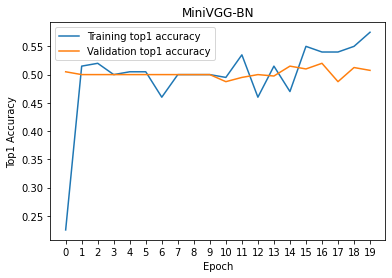

In [51]:
# visualize the training / validation accuracies

x = np.arange(num_epochs)


# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_BN)
plt.plot(x, val_his_BN)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()


In [45]:
def accuracy(output, target, topk=(1,)):
    '''
    Computes the accuracy over the k top predictions for the specified values of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    '''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [53]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
# uncomment these two lines to load pretrained weights
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
print(vgg_BN.eval()) 
test(vgg_BN, dataloaders['test'])



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
  

RuntimeError: ignored